# TP Grupal ALC-métodos


## TODO

### TP 1
- [x] Arreglar el K
- [ ] 1: consultar y corregir.
- [ ] 2: corregir
- [ ] 3: hacer un subplot con todos los mapas con un subplot.
- [ ] 3c: corregir lo siguiente

<font color='orange'>Nico: Hay que identificar el top 3 para cada m (idem por alfa). Dicho de otra manera, queremos plotear la evolución del ranking de todo museo que alguna vez fue relevante al variar m (estuvo en el top3). Esto nos permite hacer una análisis un poco más profundo luego. </font>


- [ ] 3 (análisis)
  - [ ] Buscar ejemplos que respalden el análisis, mostrarlos.
  - [ ] Hacer mapa con flechas para mostrar cómo se transfiere la relevancia.
  - [ ] Entender qué significa que se transfiera la relevancia.
  - [ ] Contestar la pregunta de estabilidad. Dar noción de estabilidad y poner ejemplos.
- [ ] 6: desarrollo en $\LaTeX$ de lo que estamos estimando, descripción.

In [ ]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy

np.seterr(divide='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [ ]:
try:
    import google.colab
    import requests

    url = "https://raw.githubusercontent.com/z101ctrl/uba-alc/refs/heads/main/template_funciones.py"
    code = requests.get(url).text
    exec(code)

except ImportError:
    from google.colab import drive
    import sys
    drive.mount('/content/drive/', force_remount=True)
    sys.path.append('/content/drive/MyDrive/ALC/')
    %load_ext autoreload

    %autoreload 2
    from template_funciones import *
import requests



# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [ ]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

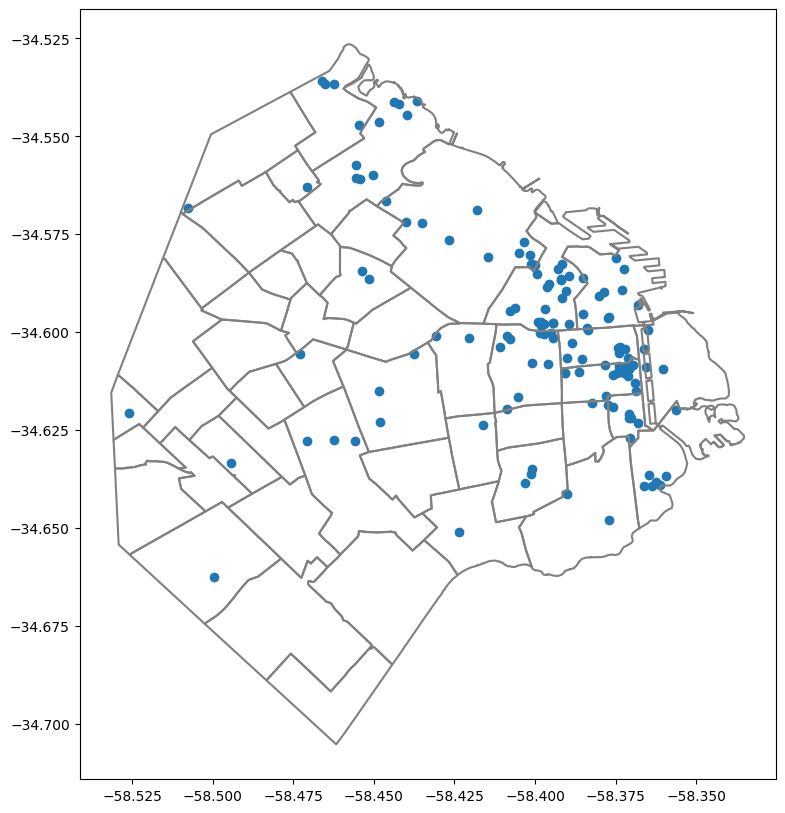

In [ ]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184.

In [ ]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa),
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [ ]:
m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [ ]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

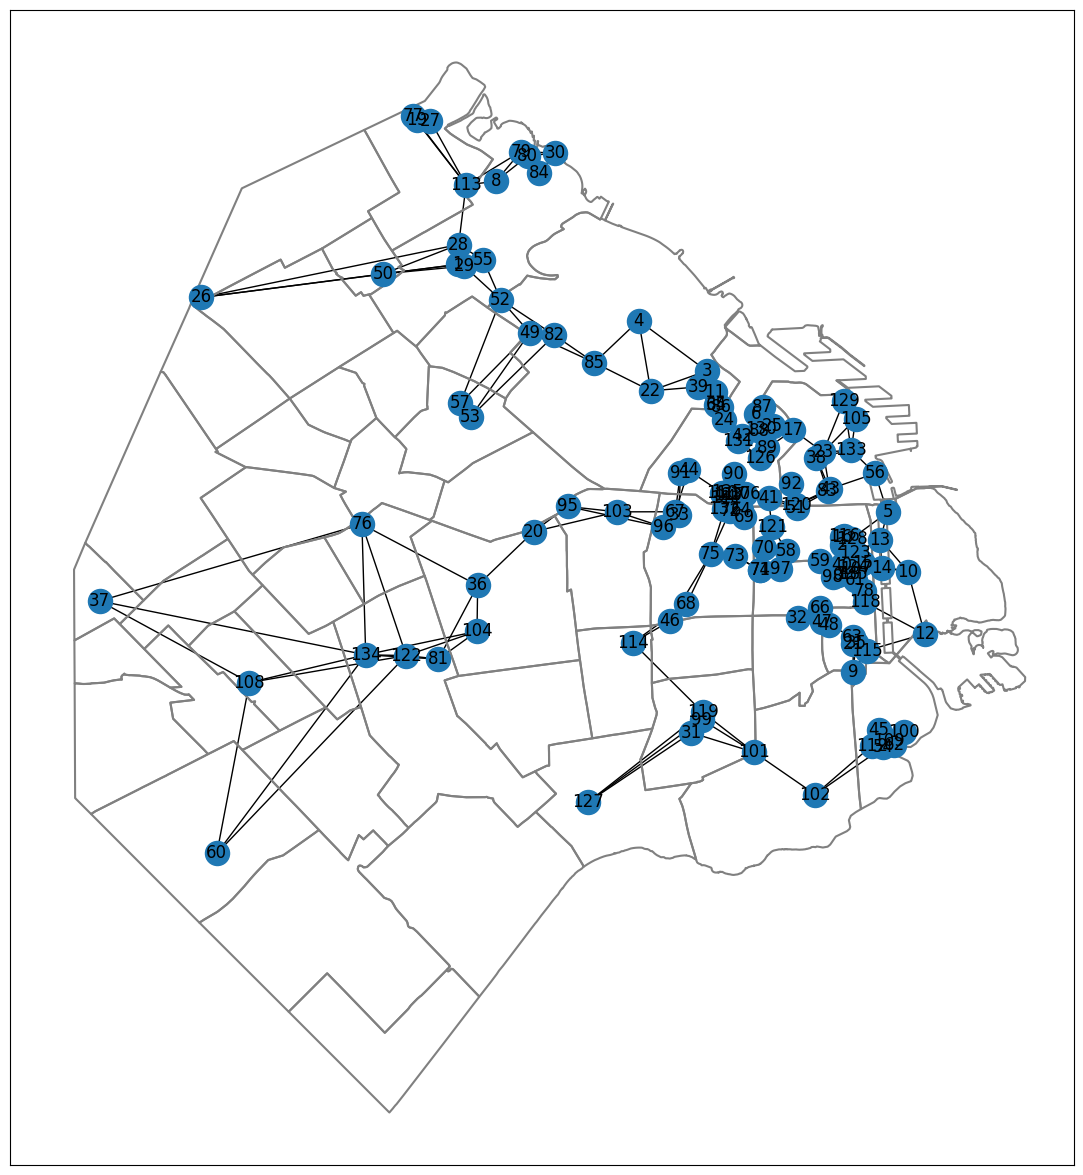

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

In [ ]:
def tres_museos_mas_centrales(C):
  """
  Dada la matriz C, devuelve los indices de los 3 museos mas centrales.

  Input:
    C: matriz de NxN

  Output:
    índices de los 3 museos mas centrales
  """
  # lista con cant. de elementos por columna.
  col_count = []
  for i in range(C.shape[1]):
      count = 0
      for elem in C[:,i]:
          count += 1 if elem != 0 else 0
      col_count.append(count)
  return np.argsort(col_count)[-3:]

## Punto 1:

Queremos ver que $\ M\vec{p} = \vec{b} \ \ $
con $\ \ M = \frac{N}{\alpha} \Bigl(I-\bigl(1-\alpha\bigl)C\Bigl) \ \ $
y $\ \ \vec{b} = \vec{1}$

\

$$
\text{Reemplazando:} \\
\\
M\vec{p} = \biggr[\frac{N}{\alpha} \Bigl(I-\bigl(1-\alpha\bigl)C\Bigl) \biggr] \vec{p} = \vec{1} = \vec{b} \\
\biggr[ \frac{N}{\alpha} \Bigl(I-\bigl(1-\alpha\bigl)C\Bigl) \biggr] \vec{p} = \vec{1} \\
\biggr[ \frac{N}{\alpha}I - \frac{N}{\alpha}\bigl(1-\alpha\bigl)C \biggr] \vec{p} = \vec{1} \\
\frac{N}{\alpha}I\vec{p} - \frac{N}{\alpha}\bigl(1-\alpha\bigl)C\vec{p} = \vec{1} \\
$$
\
$$
\text{Además, sabemos la ecuación de } \vec{p}: \\
\vec{p} = (1-\alpha)C\vec{p} + \frac{\alpha}{N}\vec{1}
$$
\
$$
\text{Reemplazando:} \\
\\
\frac{N}{\alpha}I \biggr[ (1-\alpha)C\vec{p} + \frac{\alpha}{N}\vec{1} \biggr] - \frac{N}{\alpha}\bigl(1-\alpha\bigl)C\vec{p} = \vec{1} \\
\frac{NI}{\alpha} (1-\alpha)C\vec{p} + \frac{N\alpha}{N\alpha}\vec{1}  - \frac{N}{\alpha}\bigl(1-\alpha\bigl)C\vec{p} = \vec{1} \\
\frac{N}{\alpha} I (1-\alpha)C\vec{p} + \vec{1}  - \frac{N}{\alpha}\bigl(1-\alpha\bigl)C\vec{p} = \vec{1} \\
$$
\
$$
\text{Como } IA = A: \\
\\
\frac{N}{\alpha} (1-\alpha)C\vec{p} + \vec{1}  - \frac{N}{\alpha}\bigl(1-\alpha\bigl)C\vec{p} = \vec{1} \\
$$
\
$$
\text{Cancelando nos queda finalmente:} \\
\vec{1} = \vec{1} \\
\text{Por ende probamos que es solución} \\
$$

## Punto 2:


$$
M\vec{p} = \biggr[\frac{N}{\alpha} \Bigl(I-\bigl(1-\alpha\bigl)C\Bigl) \biggr] \vec{p} = \vec{b} \quad \text{tiene solucion unica}
\quad \Longleftrightarrow \quad
Nu(M)=\vec{0}
$$
\
$$
\text{Asumo que} \quad ∃ \ \vec{p}\neq\vec{0} \ / \ M\vec{p}=\vec{0} \\
\biggr[\frac{N}{\alpha} \Bigl(I-\bigl(1-\alpha\bigl)C\Bigl) \biggr] \vec{p} = \vec{0} \\
\Bigl(I-\bigl(1-\alpha\bigl)C\Bigl) \vec{p} = \vec{0} \\
I\vec{p}-\bigl(1-\alpha\bigl)C\ \vec{p} = \vec{0} \\
\vec{p} - \bigl(1-\alpha\bigl) C\vec{p} = \vec{0} \\
\vec{p} = \bigl(1-\alpha\bigl) C\vec{p} \\
\Vert \vec{p} \Vert_1 = \bigl(1-\alpha\bigl) \Vert C\vec{p} \Vert_1 \\
$$
\
$$
\text{Con} \quad \Vert C\vec{p} \Vert \le \Vert C \Vert \Vert \vec{p} \Vert \\
\Vert \vec{p} \Vert_1 \le \bigl(1-\alpha\bigl) \Vert C \Vert_1 \Vert \vec{p} \Vert_1 \\
$$
\
$$
\text{Asumo} \quad \Vert \vec{p} \Vert_1 \neq 0 \\
1 \le \bigl(1-\alpha\bigl) \Vert C \Vert_1 \\
$$
\
$$
\text{Donde} \quad \Vert A \Vert_1 = \max_{1 \le j \le n} \sum_{i=1}^{n} \vert a_{ij} \vert \\
\text{Sin embargo se que} \quad \forall k \in [1,n] \quad \text{vale} \ \ \sum_{i=0}^{n} C_{ki} = 1 \\
\therefore \quad \max_{1 \le j \le n} \sum_{i=1}^{n} C_{ij} = 1 \\
\text{Como} \quad \forall i,j \quad C_{ij} > 0 \\
\max_{1 \le j \le n} \sum_{i=1}^{n} |C_{ij}| = 1 \\
\Vert C \Vert_1 = 1 \\
$$
\
$$
\text{Entonces} \quad 1 \le (1-\alpha) \quad \text{ABS!} \quad \text{ya que} \ \ \alpha \in (0,1) \\
\therefore \quad \nexists \ \ \vec{p} \neq \vec{0} \quad / \quad Nu(M) \neq \vec{0} \\
\text{Es decir que esta condición se cumple por construcción de la matriz} \ M
$$

## Punto 3:

In [ ]:
# inciso a
m = 3
alfa = 1/5

# calculo
A = construye_adyacencia(D, m)
C = calcula_matriz_C(A)
p_a = calcula_pagerank(A, alfa)


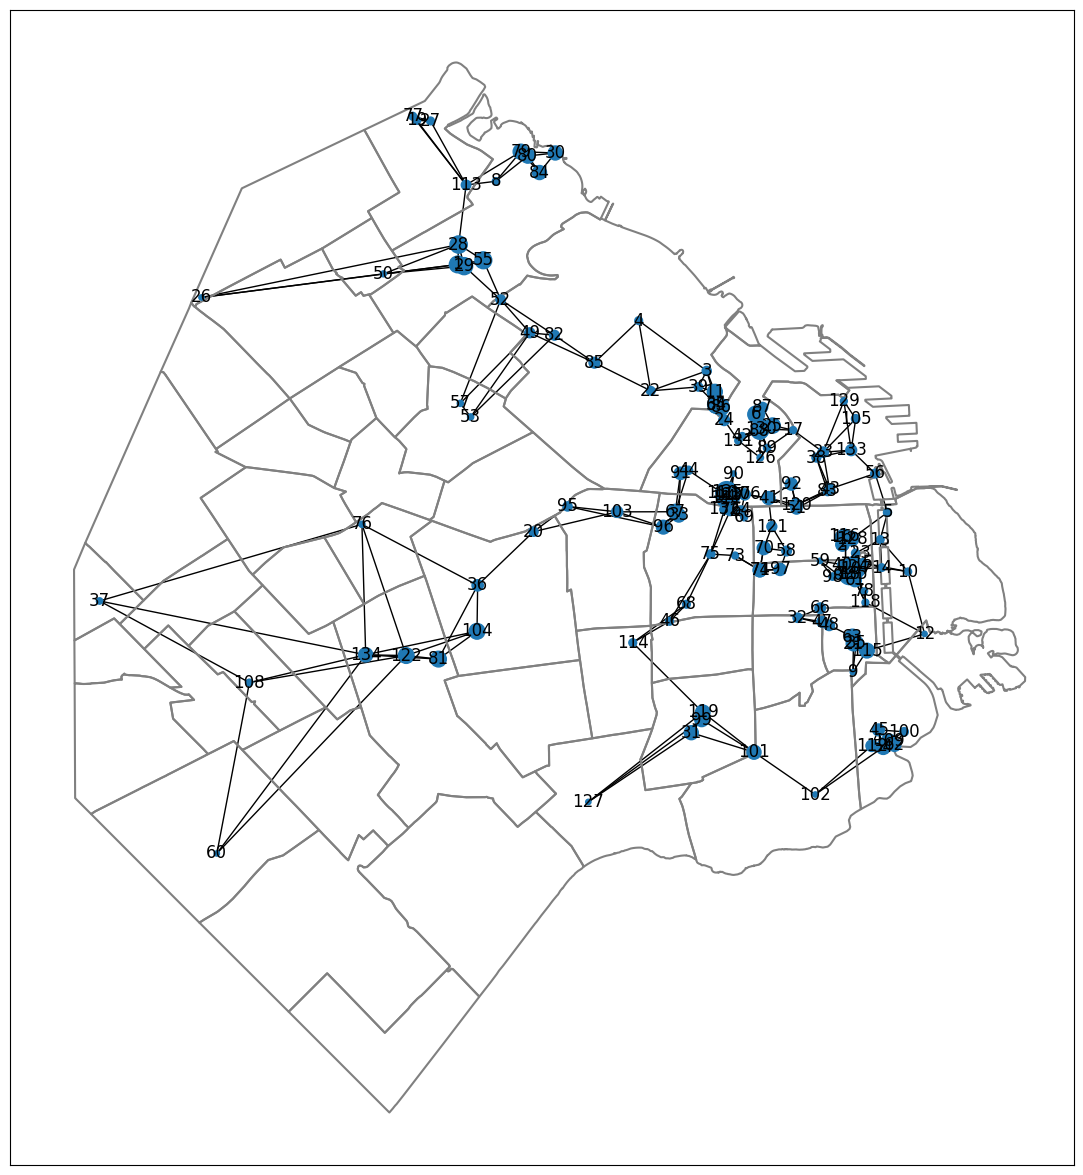

In [ ]:
# Visualizamos la red asignando un tamaño del nodo proporcional al page rank que le toca.
G = nx.from_numpy_array(C)
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

fig, ax = plt.subplots(figsize=(15, 15))
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax)
# escalamos para que se vean bien los puntos, son proporcionales a valores de p
nx.draw_networkx(G,G_layout,ax=ax, node_size = p_a * 10e3)


#### Inciso b

In [ ]:
m_list = [1, 3 , 5, 10]
alfa = 1/5


p_b_list = []
mas_centrales_b = []

for m in m_list:
  A = construye_adyacencia(D, m)
  p_b_list.append(calcula_pagerank(A, alfa))

  if mas_centrales_b == []:
    for museo in tres_museos_mas_centrales(C):
      mas_centrales_b.append(museo)


Text(0, 0.5, 'Puntaje')

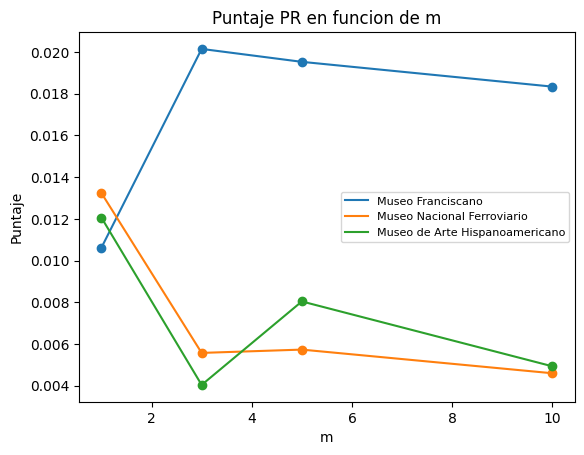

In [ ]:
"""
Identificamos 3 museos mas centrales por C y graficamos puntaje en funcion de
parámetro a variar.
"""

museos_mas_centrales = list(museos["name"].loc[mas_centrales_b])

p_individuales = []
for idx in mas_centrales_b:
  p = []
  for elem in p_b_list:
    p.append(elem[idx])
  p_individuales.append(p)

for i, p in enumerate(p_individuales):
  plt.scatter(m_list, p)
  l, = plt.plot(m_list, p)
  l.set_label(museos_mas_centrales[i],)
  plt.legend(fontsize=8)
plt.title("Puntaje PR en funcion de m")
plt.xlabel("m")
plt.ylabel("Puntaje")


Construimos mapa donde vamos cambiando el tamaño de los puntos en función del parámetro a cambiar.

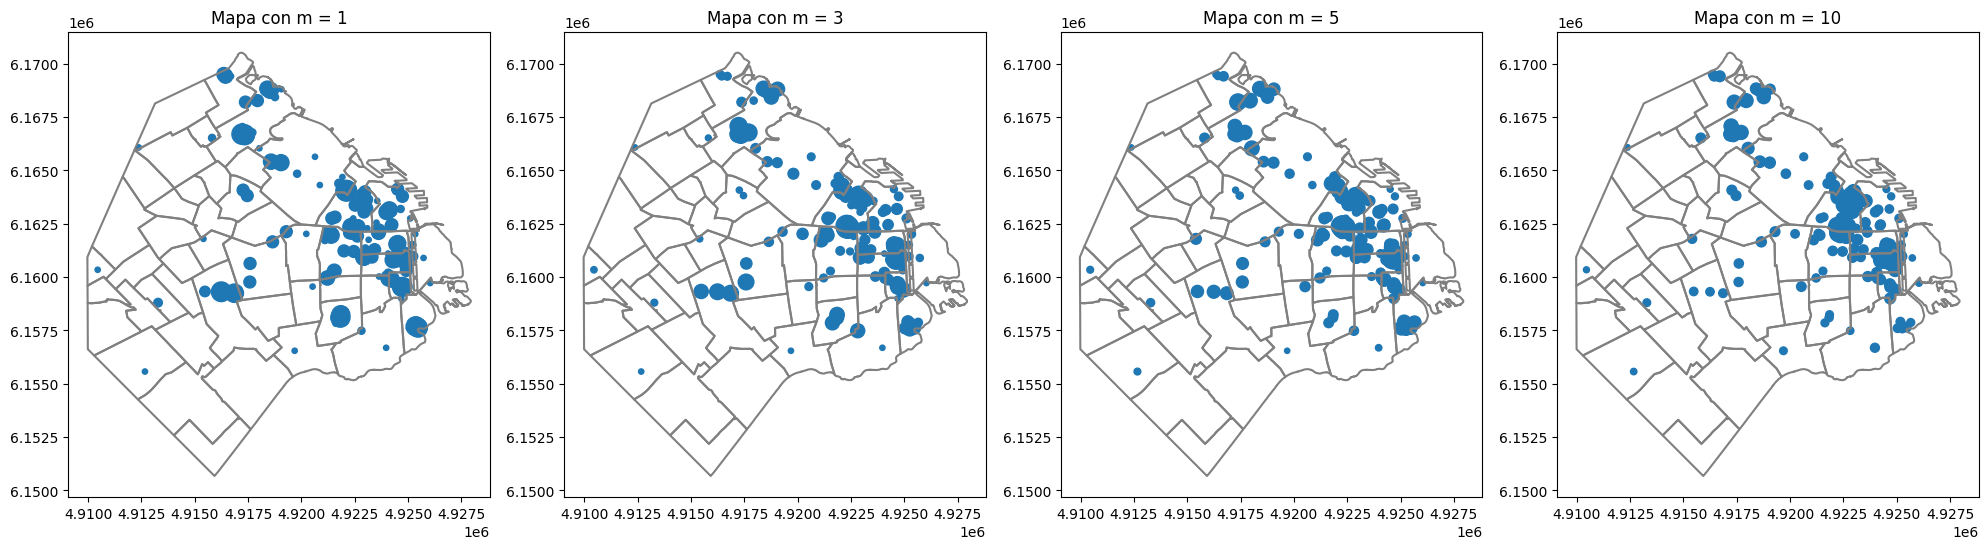

In [ ]:
# obtenemos coordenadas
museos_proj = museos.to_crs("EPSG:22184")
G_x = museos_proj.get_coordinates()['x']
G_y = museos_proj.get_coordinates()['y']
barrios_proj = barrios.to_crs("EPSG:22184")

n = len(p_b_list)

fig, axes = plt.subplots(1, n, figsize=(5 * n, 15))  # fila única, ancho proporcional, altura fija

if n == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    barrios_proj.boundary.plot(color='gray', ax=ax)
    ax.scatter(G_x, G_y, s=p_b_list[i] * 1e4)
    ax.set_title(f"Mapa con m = {m_list[i]}")

plt.tight_layout()
plt.show()

#### Análisis

Podemos observar que al aumentar $m$, cambian las posiciones del ranking con respecto al valor inicial, por lo que no se observa estabilidad.

A medida que aumentamos el $m$, se observa que el puntaje de los museos que se encuentran en zonas más densas aumenta rápidamente. Sin embargo, cuando el $m$ excede la cantidad de museos que se encuentran en esa zona de mayor densidad, el puntaje se empieza a distribuir de forma más homogénea.

Notamos que hay museos que comienzan siendo relevantes, y luego no lo son. Esto se puede observar, por ejemplo, con el puntaje del Museo Nacional Ferroviario. Que con un valor pequeño de $m$, su puntaje es mayor, pero a medida que $m$ aumenta, su puntaje disminuye.


### Inciso c

In [ ]:
m = 5
alfa_list = [6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7]
alfa_list_str = ["6/7", "4/5", "2/3", "1/2", "1/3", "1/5", "1/7"]

p_c_list = []
mas_centrales_c = []

for alfa in alfa_list:
  A = construye_adyacencia(D, m)
  p_c_list.append(calcula_pagerank(A, alfa))
  for museo in tres_museos_mas_centrales(C):
    mas_centrales_c.append(museo)

# sacamos repetidos
mas_centrales_c = list(set(mas_centrales_c))

Text(0, 0.5, 'Puntaje')

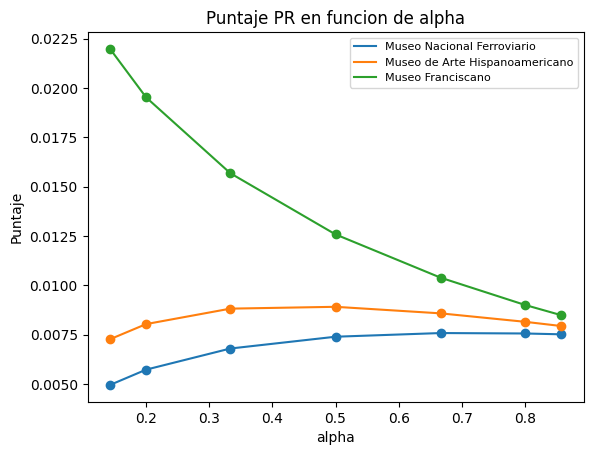

In [ ]:
"""
Identificamos 3 museos mas centrales por C y graficamos puntaje en funcion de
parámetro a variar.
"""

museos_mas_centrales = list(museos["name"].loc[mas_centrales_c])

p_individuales = []
for idx in mas_centrales_c:
  p = []
  for elem in p_c_list:
    p.append(elem[idx])
  p_individuales.append(p)

for i, p in enumerate(p_individuales):
  plt.scatter(alfa_list, p)
  l, = plt.plot(alfa_list, p)
  l.set_label(museos_mas_centrales[i],)
  plt.legend(fontsize=8)

plt.title("Puntaje PR en funcion de alpha")
plt.xlabel("alpha")
plt.ylabel("Puntaje")

Construimos mapa donde vamos cambiando el tamaño de los puntos en función del parámetro a cambiar.

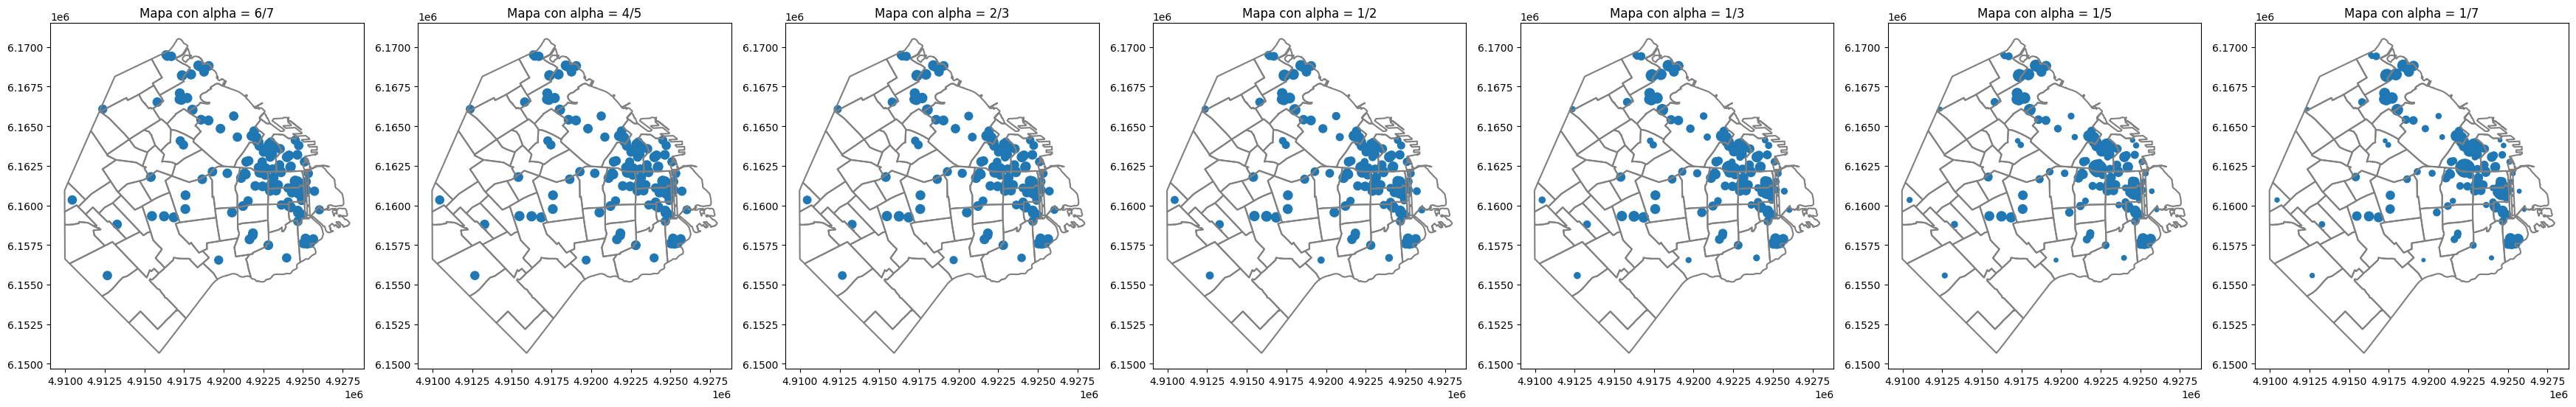

In [ ]:

# Proyectamos una sola vez
museos_proj = museos.to_crs("EPSG:22184")
G_x = museos_proj.get_coordinates()['x']
G_y = museos_proj.get_coordinates()['y']
barrios_proj = barrios.to_crs("EPSG:22184")

# Parámetros
n = len(p_c_list)

# Subplots en una sola fila
fig, axes = plt.subplots(1, n, figsize=(5 * n, 6))  # ancho proporcional a la cantidad de plots

# Asegurarse que axes es iterable
if n == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    barrios_proj.boundary.plot(color='gray', ax=ax)
    ax.scatter(G_x, G_y, s=p_c_list[i] * 1e4)
    ax.set_title(f"Mapa con alpha = {alfa_list_str[i]}")

plt.tight_layout()
plt.show()


#### Análisis

A medida que  $\alpha$ se acerca a 1, los puntajes de los museos parecen converger a un mismo punto con la particularidad de que las posiciones en el ranking se mantienen relativamente estables.

Esto sucede debido a que a medida que alpha se acerca a 1, la conexión entre museos pierde relevancia y la gana el factor aleatorio. Esto implica que mientras menor sea el valor de alpha más relevantes serán los museos con mayor cantidad de conexiones.

## Punto 4:


Sea $w$ la cant. de visitantes totales de los museos.

En particular llamaremos $w_i$ a la cant. de visitantes después de $i$-recorridos. Análogamente llamaremos $v_j$ a la distribución de visitantes en el $j$-ésimo recorrido.

$$
\vec{w}_r = \vec{v}_0 + \vec{v}_1 + \vec{v}_2 + \dots + \vec{v}_{r-1} \\
\text{donde} \quad \vec{v}_r = C^r \vec{v}_0 \\
\vec{w}_r = \vec{v}_0 + C^1 \vec{v}_0 + C^2 \vec{v}_0 + \dots + C^{r-1} \vec{v}_0 \\
\vec{w}_r = \sum_{k=0}^{r-1} C^k \vec{v}_0 \\
\quad \text{Llamamos a } \vec{v}_0 = \vec{v} \text{  y  } \vec{w}_r = \vec{w} \\
{Entonces} \quad \vec{w} = \sum_{k=0}^{r-1} C^k \vec{v} \quad \text{y sabemos que} \quad \sum_{k=0}^{r-1} C^k = B  \\
\vec{w} = B \: \vec{v} \\
\text{Asumimos que B tiene inversa. Finalmente:} \\
\vec{v} = B^{-1} \vec{w}
$$

## Punto 5:

In [ ]:
# cargamos v del archivo visitas.
import urllib.request

data = urllib.request.urlopen('https://raw.githubusercontent.com/z101ctrl/alc-metodos/refs/heads/main/visitas.txt')

visitas = []
for line in data:
  visitas.append(float(line.decode().strip()))

visitas = np.array(visitas)

In [ ]:
r = 3
C = calcula_matriz_C_continua(D)
B = calcula_B(C, r)
B_inv = inv(B)
v = B_inv @ visitas

cantidad_visitantes_iniciales = sum([abs(i) for i in v])
print("La norma 1 de v es:", cantidad_visitantes_iniciales)

La norma 1 de v es: 136604.99999999994


## Punto 6:

In [ ]:
condicion_1 = numero_de_condicion_1(B)
cota_error = condicion_1 * 0.05
print("La cota para el error es de", cota_error)
print("El número de condición de B es", condicion_1)

La cota para el error es de 0.25258855883325027
El número de condición de B es 5.051771176665005


#Parte 2


### Parte teórica

#### 1a
*Mostrar que el vector de unos es autovector de las matrices $R$ y $L$. ¿Qué autovalor tiene? ¿Qué agrupación de la red representa?*

$\vec{1}$ es autovector sii $\exists \lambda, \alpha / R \vec{1} = \lambda \vec{1}$ y $L\vec{1} = \alpha \vec{1}$

Vamos con $L$. Sabemos que $L = K - A$ por lo que
$$
L \vec{1} = (K - A) \vec{1} = K\vec{1} - A\vec{1}
$$

pero $K\vec{1}$ nos devuelve un vector con la suma de las filas de A.
Mientras que $A\vec{1}$ nos devuelve un vector con la suma de las columnas de $A$.
Sin embargo $A = A^t$, eso implica que la suma de las columnas de $A$ es igual a la suma de las filas de $A$. Por lo tanto $K\vec{1} = A\vec{1}$ Teniendo en cuenta esto

$$
L \vec{1} = (K - A) \vec{1} = K\vec{1} - A\vec{1} = \vec{0}
$$

por lo que se demuestra que $\vec{1}$ es autovector de L de autovalor $\lambda = 0$.

Vamos con $R$. Sabemos que $R = A - P$. Queremos ver que $(A - P) \vec{1} = \alpha \vec{1}$.

$$
(A - P)\vec{1} = A\vec{1} - P\vec{1} =
$$

$$
=
\begin{pmatrix}
(a_{12} + a_{13} + \ldots + a_{1n}) - (\frac{k_1 k_1}{2E}+ \ldots + \frac{k_1 k_n}{2E}) \\
\vdots \\
(a_{11} + a_{12} + \ldots + a_{nn-1}) - (\frac{k_1 k_n}{2E}+ \ldots + \frac{k_n k_n}{2E}) \\
\end{pmatrix}
$$
donde $ a_{12} + a_{13} + \ldots + a_{1n} $ es la suma de los elementos de la primera columna. Sacamos factor común $\frac{k_i}{2E}$

$$
=
\begin{pmatrix}
(a_{12} + a_{13} + \ldots + a_{1n}) - \frac{k_1}{2E}(k_1+ \ldots + k_n) \\
\vdots \\
(a_{11} + a_{12} + \ldots + a_{nn-1}) - \frac{k_n}{2E}(k_1+ \ldots + k_n) \\
\end{pmatrix}
$$
sin embargo $k_1 + \ldots + k_n = 2E$, por lo que nos queda
$$
=
\begin{pmatrix}
(a_{12} + a_{13} + \ldots + a_{1n}) - k_1 \\
\vdots \\
(a_{11} + a_{12} + \ldots + a_{nn-1}) - k_n \\
\end{pmatrix}
.
$$
Como dijimos antes, la sumatoria de la izquierda es la suma de la columna i-ésima, pero como $A = A^t$ eso implica que también es igual a la sumatoria de la fila i-ésima, y eso es exactamente $k_i$. Por lo que
$$
(A - P)\vec{1} = A\vec{1} - P\vec{1} = 0\vec{1}
$$
donde $\vec{1}$ será autovector de autovalor $\alpha = 0$.

 $\square$


Esto representa el caso trivial en el que toda la red pertenece a una misma agrupación.


#### 1b
*Muestren que si $L$ u $R$ tienen dos autovectores $v_1$ y $v_2$ asociados a autovalores $\lambda_1 \neq \lambda_2$ entonces $v_1^tv_2 = 0$.*

Sabemos que $L$ y $R$ son simétricas, debido a que ambas están conformadas por una suma de matrices simétricas. Haremos la prueba para una matriz simétrica $M$ por lo que luego valdrá tanto para $R$ como para $L$.

Sean $\lambda_1$ y $\lambda_2$ autovalores distintos y $v_1$ y $v_2$ sus respectivos autovectores asociados, entonces valen las siguientes ecuaciones:
$$
(I) \quad M v_1 = \lambda v_1  \\ (II) \quad M v_2 = \lambda_2 v_2
$$

De $(I)$ vemos que
$$
Mv_1 = \lambda_1 v_1 \Rightarrow v_1^tM^t = \lambda_1 v_1^t \Rightarrow v_1^tM = \lambda_1 v_1^t
$$
donde usamos que $M$ es simétrica. Multiplicamos la última expresión por $v_2$ de ambos lados, obteniendo
$$
v_1^tMv_2= \lambda_1 v_1^tv_2 \Rightarrow v_1^t v_2\lambda_2 = \lambda_1 v_1^t v_2
$$
donde usamos la eq. $(II)$. Sin embargo, dado que los autovalores son distintos, esa última igualdad solo puede satisfacerse sii $v_1^tv_2 = 0$

$\square$




#### 1C
*Muestren que si $v$ es un autovector de autovalor $\lambda \neq 0$ de $R$ o $L$, entonces $\sum_i v_i = 0$*

Dado que $L$ y $R$ son matrices simétricas, entonces vale que $v_i^t v_j = 0 \quad \forall i, j / i \neq j$ siendo $v_i$ el i-ésimo autovector.

Como sabemos que $\vec{1}$ es autovector, entonces vale que $\vec{1}v = 0$, lo que es equivalente a decir $\sum_i v_i = 0$.

$\square$

#### 2a
Muestre que los autovalores de $M + \mu I$ son $\gamma_i = \lambda_i + \mu$ y que el autovector asociado a $\gamma_i$ es $v_i$. Concluya que si $\mu + \lambda_i \neq 0 \quad \forall i$, entonces $M + \mu I$ es inversible.

Queremos ver que $(M + \mu I) v_i = (\lambda_i + \mu) v_i$.

Sea $w_i$ un autovector de $M + \mu I$ correspondiente al autovalor $\gamma_i$, entonces
$$
(M + \mu I ) w_i = \gamma_i w_i \
M w_i+ \mu I w_i = \gamma_i w_i \
M w_i+ \mu w_i = \gamma_i w_i \
$$
donde esta igualdad vale sii $w_i = v_i$ y $M v_i = \lambda_i v_i$ por lo que $\gamma_i = \lambda_i + \mu$ siendo $v_i$ el i-esimo autovector asociado al autovalor $\lambda_i$ de de la matriz $M$. $\square$

Para demostrar inversibilidad se debe cumplir $det(M+\mu I) \neq 0$, donde $M$ es diagonalizable. Por lo que
$$
det(M + \mu I) = det(P D P^{-1} + \mu I)
$$
donde $M = P D P^{-1}$ siendo $D$ diagonal y $P, P^{-1}$ las matrices de cambio de base.
$$
= det(P D P^{-1} + \mu I) \
= det (P P^{-1} D + \mu I) = det(D + \mu I) = \prod_i^n (\lambda_i + \mu_i)
$$
por lo que si $\mu + \lambda_i \neq 0 \quad \forall i ⇒det(M + \mu I) \neq 0$ y la matriz es inversible. $\square$




#### 2b
*Considerando $\mu > 0$, muestren que $L + \mu I$ es inversible, con $L$ el laplaciano definido en la ecuación 2. Muestren que al aplicar el método de la potencia a $(L + \mu I)^{-1}$ converge a su autovector de autovalor más chico si se parte de una semilla adecuada. Indique, en el caso de que haya un solo autovector con dicho autovalor, cuál es dicho autovector y cuánto vale su autovalor.*

Quiero ver que $(L + \mu I)^{-1}$ es inversible. Sabemos que $L = K - A$ y que $L$ es simétrica, por lo tanto admite una descomposición en vectores ortogonales. Es decir que $L = P D P^{-1}$ con $D$ matriz diagonal y $P, P^{-1}$ matrices de cambio de base.
$$
det(L + \mu I) = det(P D P^{-1} + \mu I) = det(D + \mu I) = \prod_i^n (\lambda_i + \mu)
$$
Con $\lambda_i / L v_i = \lambda_i v_i$. Sin embargo $\lambda_i = 0 \quad \forall i$ ya que $tr(L) = 0 ⇒ tr(D + \mu I) = \mu^n > 0$ por lo que $det(L +\mu I) \neq 0$. $\square$

Ahora quiero ver que el método de la potencia sobre $(L + \mu I)^{-1}$ me devuelve el autovector con el autovalor asociado más chico.

Dado un vector $w = a_1 v_1 + a_2 v_2 + \ldots + a_n v_n$ siendo $v_i$ los autovectores asociados a $(L + \mu I )^{-1}$. Además sabemos que $L + \mu I$ es diagonalizable, por lo que su inversa también lo es
$$
(L + \mu I)^{-1} w = (L + \mu I)^{-1} (a_1 v_1 + \ldots + a_n v_n) \\
= (L + \mu I)^{-1} (a_1 v_1 + \ldots + a_n v_n) \\
= a_1 \gamma_1^{-1} + \ldots + a_n \gamma_n^{-1}
$$
donde $\gamma_i$ son los autovalores asociados a $(L + \mu I)$ por lo que vale que $(L+ \mu I) v_i = \gamma_i v_i ⇒ (L+ \mu I)^{-1} v_i = \gamma_i^{-1} v_i$ donde la inversa de los autovalores seran los autovalores de la inversa.

Dados $\gamma_1 > \ldots > \gamma_n$ vale que $\gamma_n^{-1} > \ldots >\gamma_1^{-1}$ por lo que el método convergerá a $v_n$, el autovector de autovalor más chico.

El método podría no converger a $v_n$ en el caso de que $w \perp v_n$, es decir que tenga componente cero en la dirección de $v_n$. En ese caso, si el $w$ tiene alguna componente en esa dirección, el vector convergerá a $v_{n-1}$

#### 2c
Suponiendo que $M$ es simétrica, muestre que la matriz $\tilde{M} = M - \lambda_1 \frac{v_1 v_1^t}{v_1^t v_1}$ tiene los mismos autovectores que $M$, pero el autovalor asociado a $v_1$ es igual a 0.

$$
\tilde{M} v_1 = (M - \lambda_1 \frac{v_1 v_1^t}{v_1^t v_1})v_1 \
= M v_1 - \lambda_1 \frac{v_1 v_1^t}{v_1^t v_1} v_1 \
= \lambda_1 v_1 - \lambda_1 v_1 \frac{v_1^t v_1}{v_1^t v_1} = 0
$$
Por lo que el autovalor asociado a $v_1$ es igual a 0.

Agarro $Mv_i = \lambda_i v_i$, veo que pasa cuando hago $\tilde{M} v_i$

$$
\tilde{M} v_i = (M - \lambda_1 \frac{v_1 v_1^t}{v_1^t v_1})v_i = M v_i  - \lambda_1 \frac{v_1 v_1^t}{v_1^t v_1}v_i \
= \lambda_i v_i  - \lambda_1 \frac{v_1 v_1^t}{v_1^t v_1}v_i \
= (\lambda_i  - \lambda_1 \frac{v_1 v_1^t}{v_1^t v_1})v_i
$$
por lo que cualquier autovector $v_i$ con $i \neq 1$ será autovector de $\tilde{M}$.
$\square$

### Parte computacional

Acá definimos las funciones que luego usaremos para nuestro análisis. Definimos una seed de `numpy` para que las funciones nos devuelvan el mismo valor a pesar de correrlo varias veces. Tenemos que hacer esto debido a que algunos métodos se valen de obtener números/vectores aleatorios.

#### 4

### Análisis de comunidades en la red de museos

#### 1. **Construcción de la red**
- Utilizar la red de museos definida en el TP anterior.
- Construir la matriz de adyacencia $A$ para distintos valores de $m$:  
  - $m = 3$  
  - $m = 5$  
  - $m = 10$  
  - $m = 50$
- Simetrizar la matriz de adyacencia utilizando la fórmula:  
  $A' = \lceil \frac{1}{2}(A + A^T) \rceil$  
  donde:
  - $A^T$ es la transpuesta de $A$
  - $\lceil x \rceil$ es la función techo (ceiling)

#### 2. **Detección de comunidades**

##### Método basado en el **laplaciano**:
- Aplicar el algoritmo recursivo de corte usando el segundo autovector del Laplaciano.
- Obtener las particiones óptimas para cada valor de $m$.

##### Método basado en la **modularidad**:
- Aplicar el algoritmo de optimización de modularidad recursivamente.
- Obtener las particiones óptimas para cada valor de $m$.

#### 3. **Análisis de resultados de la modularidad**
- Explorar cómo cambia la **estructura de comunidades** cuando se modifica $m$:
  - Número de comunidades.
  - Tamaño de las comunidades.
  - Ubicación de las comunidades en el mapa (regiones).
  - Estabilidad de las comunidades frente a diferentes ejecuciones.

#### 4. **Comparación entre métodos**
- Comparar visualmente las particiones obtenidas por:
  - El método del **laplaciano**.
  - El método de **modularidad**.
- Buscar un número de **niveles** en el método del laplaciano que produzca una cantidad de comunidades **comparable** a la del método de modularidad.

#### 5. **Discusión**
- Discutir los resultados obtenidos:
  - Diferencias entre métodos.
  - Robustez de cada técnica.
  - Efecto del parámetro $m$.
  - Interpretación de las comunidades en el contexto geográfico o cultural.



#### Preguntas (internas)
- ¿Qué significa calcular las particiones óptimas?
  Entiendo qué óptimas según el método, es decir que al momento de pasársela a nuestras funciones, estas son nuestras particiones que optimizan lo que queremos (minimizar el error).
- Decidir cómo mostrar y mostrar lo siguiente:
  - [ ] Variación de la cantidad de grupos según el $m$.
  - [ ] Variación del tamaño de los grupos según el $m$ (este es difícil!).
  - [ ] Regiones del mapa que ocupan cada una de estas.
  - [ ] Cómo cuantificar estabilidad (nos había quedado pendiente del 1)
  - [ ] ¿Cómo mostramos la estabilidad de los grupos entre emes?
  - [ ] ¿Cómo comparar ambos métodos?
    - En principio visualmente, pero podríamos buscar otras maneras.

- El problema es en encontrar la manera de matchear los grupos entre iteraciones.


Calculamos las particiones óptimas utilizando ambos métodos, utilizando la matriz simetrizada.


#### Funciones graficadoras

In [ ]:
import random
from shapely.geometry import MultiPoint





def crear_labels(lista_matrices):
  a = 0.2
  colores = list(plt.cm.tab20.colors) + [(x*a,y*a,z*a) for (x,y,z) in list(plt.cm.tab20.colors)]
  dict_labels = {}

  for i, matriz in enumerate(lista_matrices):
    dict_labels[i] = {}
    for j, grupo in enumerate(matriz):
      for elem in grupo:
        dict_labels[i][elem] = colores[j]
  return dict_labels


def subplots_aristas(lista_matrices_sim, dict_labels, title):
  n = len(lista_matrices_sim)
  fig, axes = plt.subplots(1, n, figsize=(5 * n, 6))

  for i, ax in enumerate(axes):
      A = lista_matrices_sim[i]
      G = nx.from_numpy_array(A)

      G_layout = {j: (G_x[j], G_y[j]) for j in G.nodes}

      barrios_proj.boundary.plot(color='gray', ax=ax)

      colors = [dict_labels[i][j] for j in range(len(G_x))]
      ax.scatter(G_x, G_y, color=colors)
      nx.draw_networkx_edges(G, pos=G_layout, ax=ax, edge_color='black', alpha=0.3)
      nx.draw_networkx_nodes(G, pos=G_layout, ax=ax, node_color=colors, node_size=p_a * 10e3)

      ax.set_title(title[i] if isinstance(title, list) else title)
      ax.set_xlabel("Latitud (°)")
      ax.set_ylabel("Longitud (°)")
      ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

      #ax.set_axis_off()

  plt.tight_layout()
  plt.show()


def subplot_colores_puntos(lista_matrices, dict_labels, title):
  museos_proj = museos.to_crs("EPSG:22184")
  G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}
  G_x = museos_proj.get_coordinates()['x']
  G_y = museos_proj.get_coordinates()['y']
  barrios_proj = barrios.to_crs("EPSG:22184")

  # params
  n = len(lista_matrices)

  # subplots
  fig, axes = plt.subplots(1, n, figsize=(5 * n, 6))  # ancho proporcional a la cantidad de plots


  # TODO: queremos que más o menos se mantengan los colores entre valores de m
  for i, ax in enumerate(axes):
      # TODO: revisar esto porque se nos va la complejidad al joraca
      colors = [dict_labels[i][j] for j in range(len(G_x))]
      barrios_proj.boundary.plot(color='gray', ax=ax)
      ax.scatter(G_x, G_y, color=colors)
      ax.set_title(title[i] if isinstance(title, list) else title)
      ax.set_xlabel("Latitud (°)")
      ax.set_ylabel("Longitud (°)")
      ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

  plt.tight_layout()
  plt.show()


def plot_group_variation_completa(lista_matrices_modular, m_values, tamanios_promedios, title='Variación de cantidad y tamaño promedio de grupos en función de m'):
    """
    Genera dos gráficos uno al lado del otro:
    - Número de grupos en función de 'm'
    - Tamaño promedio de grupos en función de 'm'

    Parámetros
    ----------
    lista_matrices_modular :
        Lista de listas, donde cada sublista representa los grupos encontrados para un valor 'm' dado.
    m_values : list o array-like
        Lista de valores 'm' correspondientes a cada entrada de lista_matrices_modular.
    tamanios_promedios : list
        Lista con el tamaño promedio de los grupos para cada valor de 'm'.
    """
    num_groups = [len(groups) for groups in lista_matrices_modular]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(m_values, num_groups, marker='o', linestyle='-', color='skyblue')
    axes[0].set_title('Número de grupos según el m')
    axes[0].set_xlabel('m')
    axes[0].set_ylabel('Número de grupos')
    axes[0].grid(True)

    axes[1].plot(m_values, tamanios_promedios, marker='s', linestyle='--', color='salmon')
    axes[1].set_title('Tamaño promedio de los grupos según el m')
    axes[1].set_xlabel('m')
    axes[1].set_ylabel('Tamaño promedio grupos')
    axes[1].grid(True)

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



def subplot_colores_puntos_region(lista_matrices, dict_labels, title):
    museos_proj = museos.to_crs("EPSG:22184")
    G_coords = museos_proj.get_coordinates()
    G_x = G_coords['x']
    G_y = G_coords['y']
    barrios_proj = barrios.to_crs("EPSG:22184")

    n = len(lista_matrices)
    fig, axes = plt.subplots(1, n, figsize=(5 * n, 6))

    if n == 1:
        axes = [axes]  # por si hay un solo plot

    for i, ax in enumerate(axes):
        colors = [dict_labels[i].get(j, (0.5, 0.5, 0.5, 1)) for j in range(len(G_x))]

        barrios_proj.boundary.plot(color='gray', ax=ax)
        ax.scatter(G_x, G_y, color=colors)

        # Agrupamos puntos por color y generamos envoltorios
        puntos_por_color = {}
        for j in range(len(G_x)):
            color = dict_labels[i].get(j)
            if color:
                puntos_por_color.setdefault(color, []).append((G_x.iloc[j], G_y.iloc[j]))

        for color, puntos in puntos_por_color.items():
            if len(puntos) < 3:
                continue  # no tiene sentido con menos de 3 puntos
            multipoint = MultiPoint(puntos)
            hull = multipoint.convex_hull
            if hull.geom_type == 'Polygon':
                xs, ys = hull.exterior.xy
                ax.fill(xs, ys, alpha=0.3, color=color, edgecolor='black', linewidth=1.5)

        ax.set_title(title[i] if isinstance(title, list) else title)
        ax.set_xlabel("Latitud (°)")
        ax.set_ylabel("Longitud (°)")
        ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

    plt.tight_layout()

def tamanio_promedio_grupos(lista_matrices):
  means = []
  for matriz in lista_matrices:
    lens = 0
    for grupo in matriz:
      lens += len(grupo)
    means.append(lens/len(matriz))
  return means


"""
Preguntas:
  - Esta forma de medir la estabilidad es para ambos métodos, no?
  En el caso de que no estaría bueno encontrar uno que aplique para ambos, porque
  entiendo que el jugo está en comparar la estabilidad entre ambos métodos.
  - Nos sería conveniente separar la parte del ploteo y la parte que nos mide la
  modularidad
  - También estaría bueno ver si lo podemos hacer independiente de m_values, ya que
  la lista de matrices no es independiente de los valores de m.
  - Estaría bien poder cambiar el título del plot.
"""
def plot_estabilidad_modularidad(lista_matrices_modular, m_values, title='Porcentaje de pares de nodos desestabilizados por transición de m'):
    """
    Calcula y grafica la "desestabilización" de la agrupación de nodos
    al pasar de un valor 'm' a otro, donde la desestabilización se define
    como el porcentaje de pares de nodos que estaban en grupos distintos
    y en la siguiente configuración de 'm' pasan a estar en el mismo grupo.

    Parámetros
    ----------
    lista_matrices_modular : list de listas de listas
        Una lista donde cada lista interna representa los grupos encontrados
        para un valor 'm' dado. Cada grupo es una lista de índices de nodos.
        Se espera que esta lista esté ordenada de mayor a menor 'm' (o al menos
        que 'm_values' esté en el orden correcto y decreciente para la interpretación).
    m_values : list o array-like
        Una lista de valores 'm' correspondientes a cada entrada en lista_matrices_modular.
        Debe tener la misma longitud y orden que lista_matrices_modular.
    """

    if not lista_matrices_modular or not m_values:
        print("Error: lista_matrices_modular o m_values no pueden estar vacías.")
        return

    if len(lista_matrices_modular) != len(m_values):
        print("Error: La cantidad de entradas en lista_matrices_modular debe coincidir con la cantidad de m_values.")
        return

    if len(lista_matrices_modular) < 2:
        print("Se necesitan al menos dos configuraciones de 'm' para calcular la estabilidad de la transición.")
        return

    asignaciones_por_m = []
    num_nodos = max(node for sublist in lista_matrices_modular[0] for node in sublist) + 1 if lista_matrices_modular[0] else 0

    if num_nodos == 0:
        print("No se encontraron nodos en las particiones.")
        return

    for particion_grupos in lista_matrices_modular:
        asignacion_actual = {}
        for grupo_id, grupo in enumerate(particion_grupos):
            for nodo in grupo:
                asignacion_actual[nodo] = grupo_id
        asignaciones_por_m.append(asignacion_actual)

    porcentajes_desestabilizacion = []
    m_transiciones_labels = []
    pares_ordenados = sorted(zip(m_values, lista_matrices_modular), key=lambda x: x[0], reverse=True)
    m_values_ordenados = [p[0] for p in pares_ordenados]
    lista_matrices_modular_ordenada = [p[1] for p in pares_ordenados]

    asignaciones_por_m_ordenadas = []
    for particion_grupos in lista_matrices_modular_ordenada:
        asignacion_actual = {}
        for grupo_id, grupo in enumerate(particion_grupos):
            for nodo in grupo:
                asignacion_actual[nodo] = grupo_id
        asignaciones_por_m_ordenadas.append(asignacion_actual)


    for i in range(len(m_values_ordenados) - 1):
        m_actual = m_values_ordenados[i]
        m_siguiente = m_values_ordenados[i+1]
        asignacion_actual = asignaciones_por_m_ordenadas[i]
        asignacion_siguiente = asignaciones_por_m_ordenadas[i+1]

        pares_desestabilizados_conteo = 0
        total_pares_distintos_en_actual = 0
        nodos = range(num_nodos)

        for idx1 in range(num_nodos):
            for idx2 in range(idx1 + 1, num_nodos):
                nodo1, nodo2 = idx1, idx2

                if nodo1 not in asignacion_actual or nodo2 not in asignacion_actual or \
                   nodo1 not in asignacion_siguiente or nodo2 not in asignacion_siguiente:
                   continue


                estaban_distintos = (asignacion_actual[nodo1] != asignacion_actual[nodo2])

                if estaban_distintos:
                    total_pares_distintos_en_actual += 1
                    ahora_mismo_grupo = (asignacion_siguiente[nodo1] == asignacion_siguiente[nodo2])

                    if ahora_mismo_grupo:
                        pares_desestabilizados_conteo += 1

        if total_pares_distintos_en_actual > 0:
            porcentaje = (pares_desestabilizados_conteo / total_pares_distintos_en_actual) * 100
        else:
            porcentaje = 0

        porcentajes_desestabilizacion.append(porcentaje)
        m_transiciones_labels.append(f"m={m_actual} a m={m_siguiente}")


    media = np.mean(porcentajes_desestabilizacion)
    desvio = np.std(porcentajes_desestabilizacion)
    lista_matrices_modular_ext
    plt.figure(figsize=(12, 7))
    plt.axhline(y=media, color='r', linestyle='--', label=f'Media ({media:.2f})')
    plt.fill_between(m_transiciones_labels, media - desvio, media + desvio, color='blue', alpha=0.1, label=f'±1 Desviación estándar ({desvio:.2f})')


    plt.plot(m_transiciones_labels, porcentajes_desestabilizacion,
             marker='o', linestyle='-', color='blue', linewidth=2)

    plt.title(title)
    plt.xlabel('Transición de valor de m (de mayor a menor)')
    plt.ylabel('Porcentaje de pares "Distintos a Mismo Grupo"')
    plt.grid(True, linestyle='--', alpha=0.7)
    #plt.xticks(rotation=45, ha='right')
    ticks_actuales = ax.get_yticks()
    ticks_nuevos = sorted(set(ticks_actuales.tolist() + [media]))
    ax.set_yticks(ticks_nuevos)
    plt.tight_layout()
    plt.legend()
    plt.show()



#### Modularidad

In [ ]:
# calculamos todas las matrices

m_list = [50, 10, 5, 3]
alfa = 1/5

lista_sim = []

for m in m_list:
  A = construye_adyacencia(D, m)
  A_sim = np.ceil(1/2*(A + A.T))
  lista_sim.append(A_sim)

In [ ]:
# calculamos las particiones óptimas utilizando ambos métodos, con las matrices simetrizadas
# grupos dentro de cada matriz
lista_matrices_modular = [modularidad_iterativo(matriz) for matriz in lista_sim]

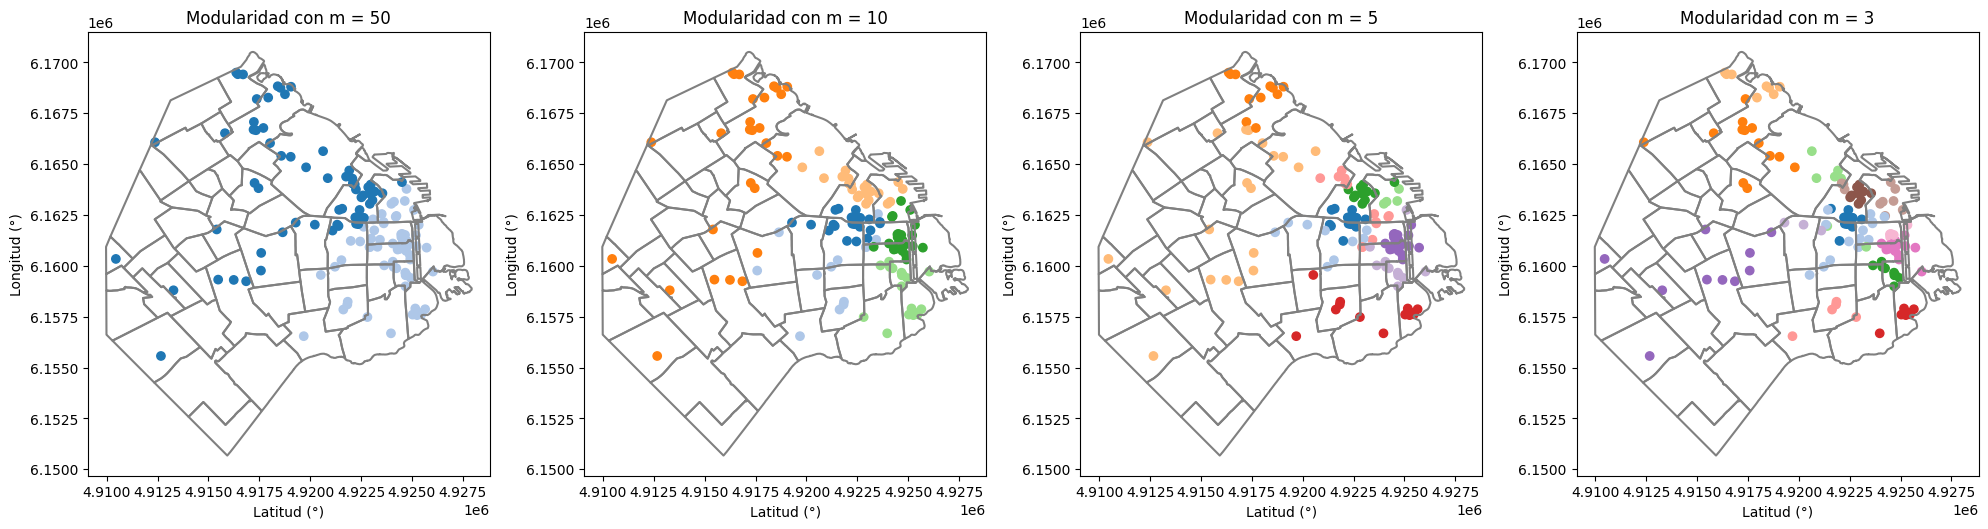

In [ ]:
# graficamos los modulos.
dict_labels = crear_labels(lista_matrices_modular)
subplot_colores_puntos(lista_matrices_modular, dict_labels, [f"Modularidad con m = {m}" for m in m_list])

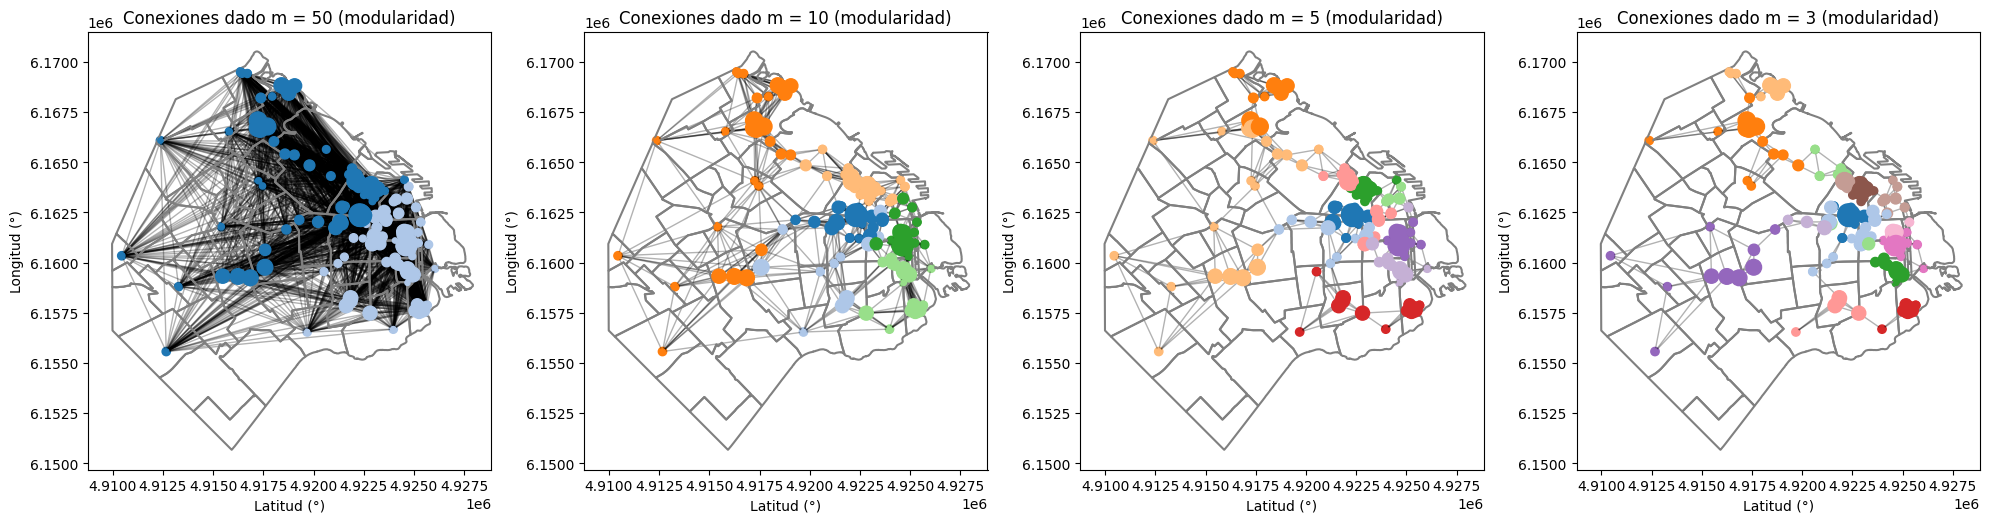

In [ ]:
subplots_aristas(lista_sim, dict_labels,  [f"Conexiones dado m = {m} (modularidad)" for m in m_list])

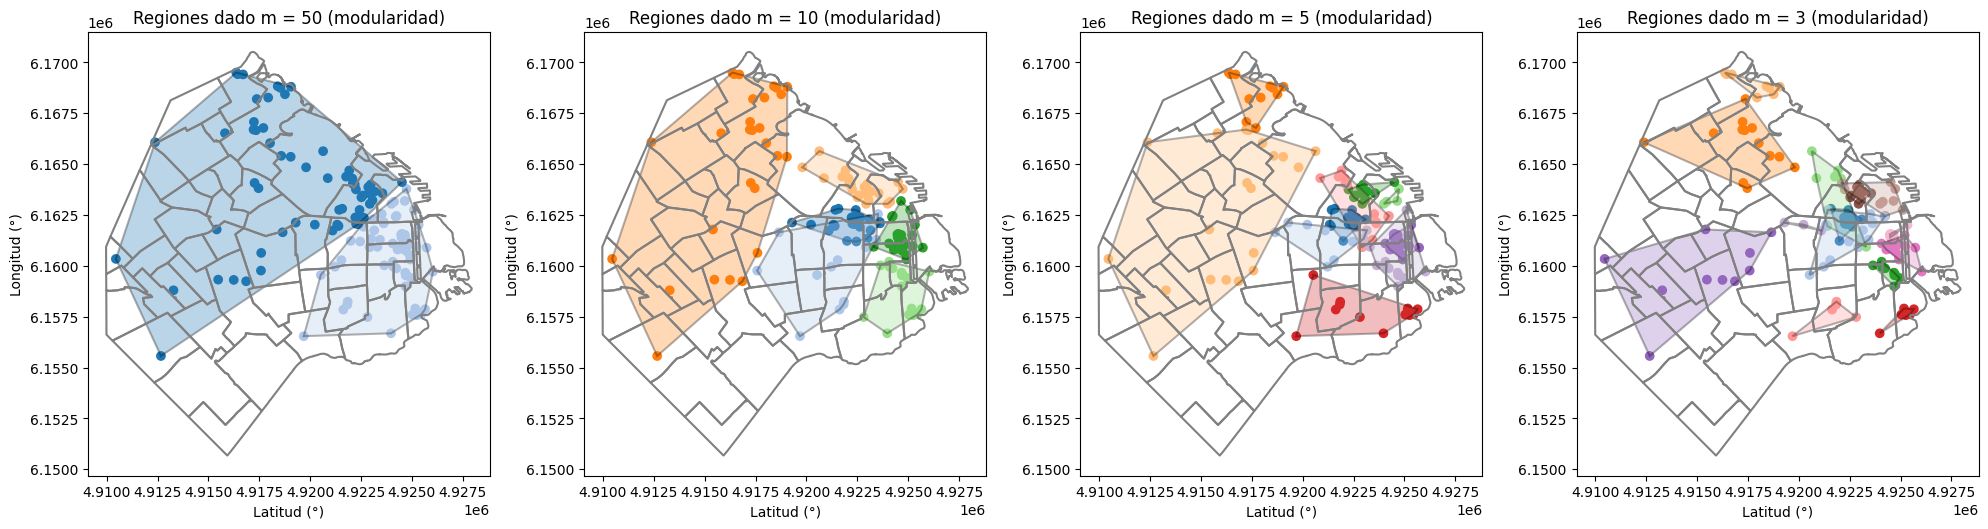

In [ ]:
subplot_colores_puntos_region(lista_matrices_modular, dict_labels, [f"Regiones dado m = {m} (modularidad)" for m in m_list])


#### Laplaciano

In [ ]:
niveles = 2
lista_matrices_laplaciano = [laplaciano_iterativo(matriz, niveles) for matriz in lista_sim]

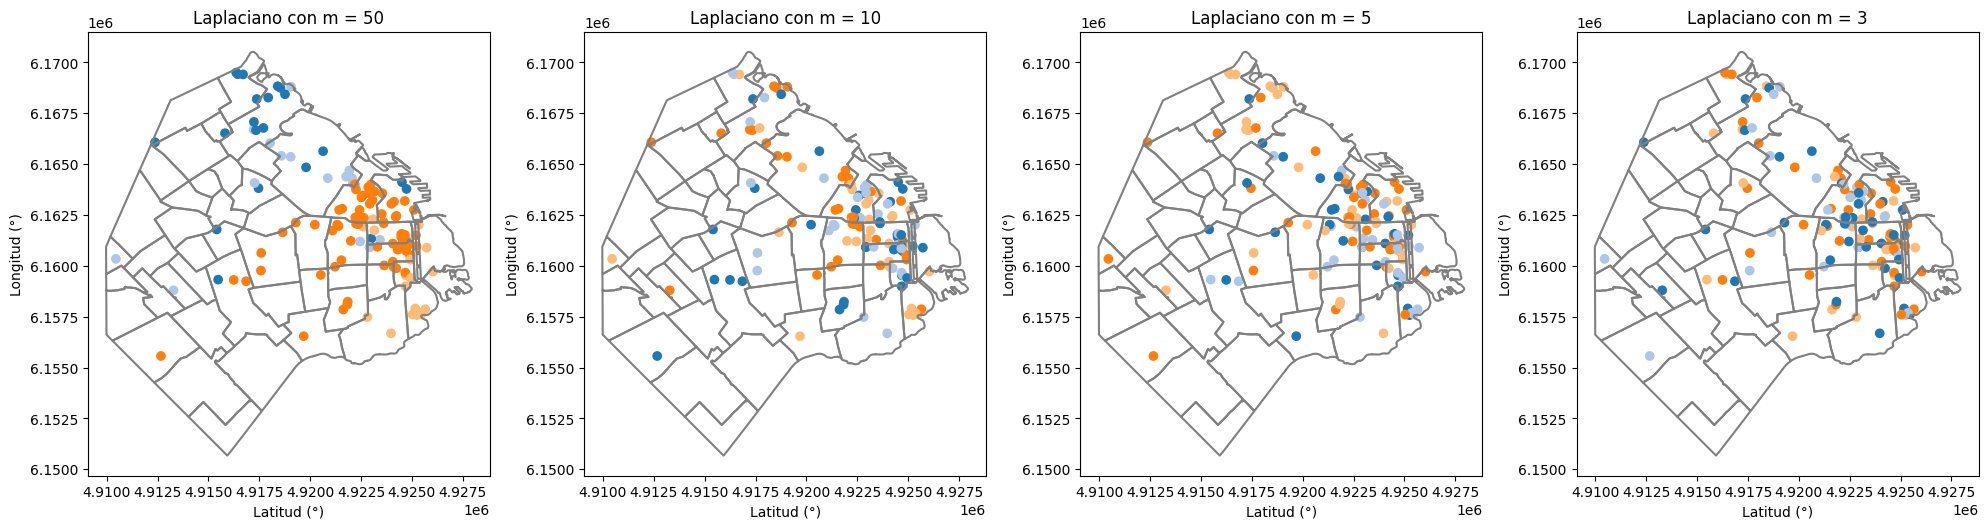

In [ ]:
dict_labels = crear_labels(lista_matrices_laplaciano)
subplot_colores_puntos(lista_matrices_laplaciano, dict_labels, [f"Laplaciano con m = {m}" for m in m_list])

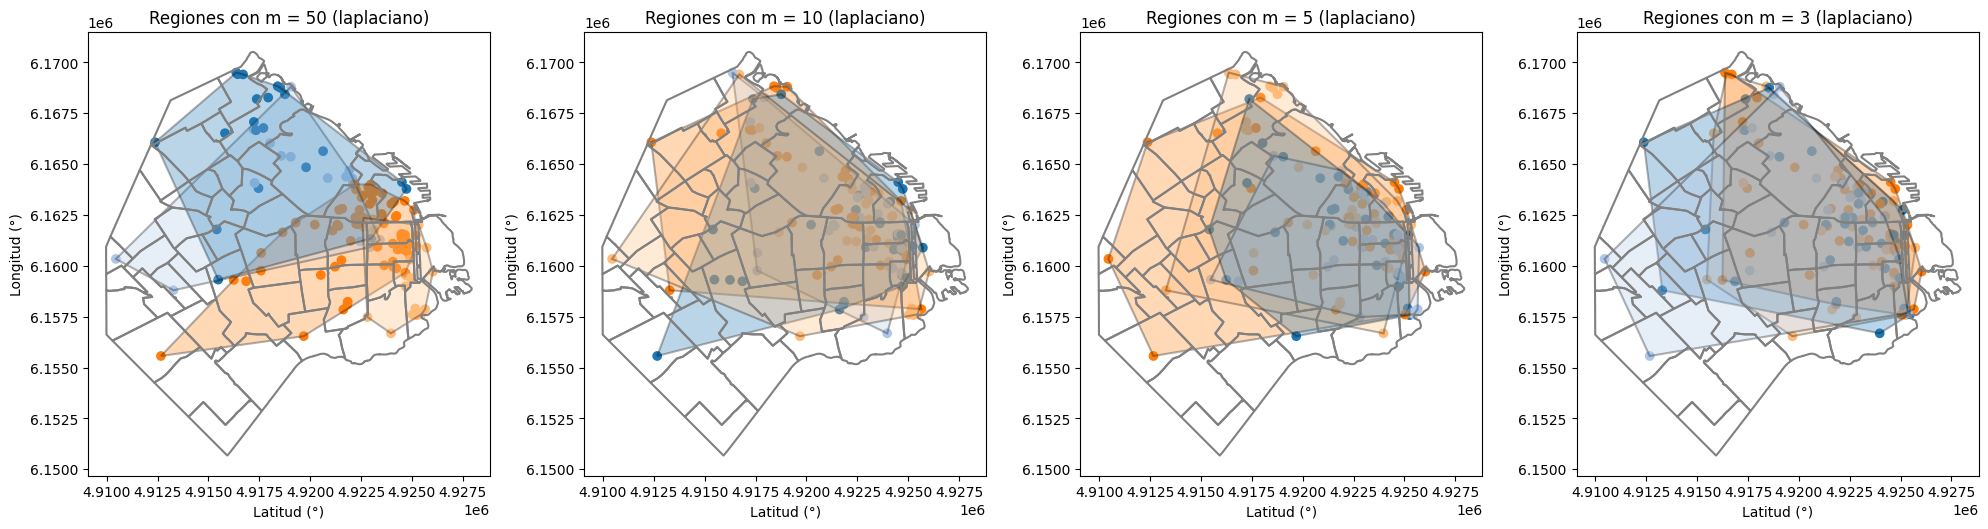

In [ ]:
subplot_colores_puntos_region(lista_matrices_laplaciano, dict_labels, [f"Regiones con m = {m} (laplaciano)" for m in m_list])

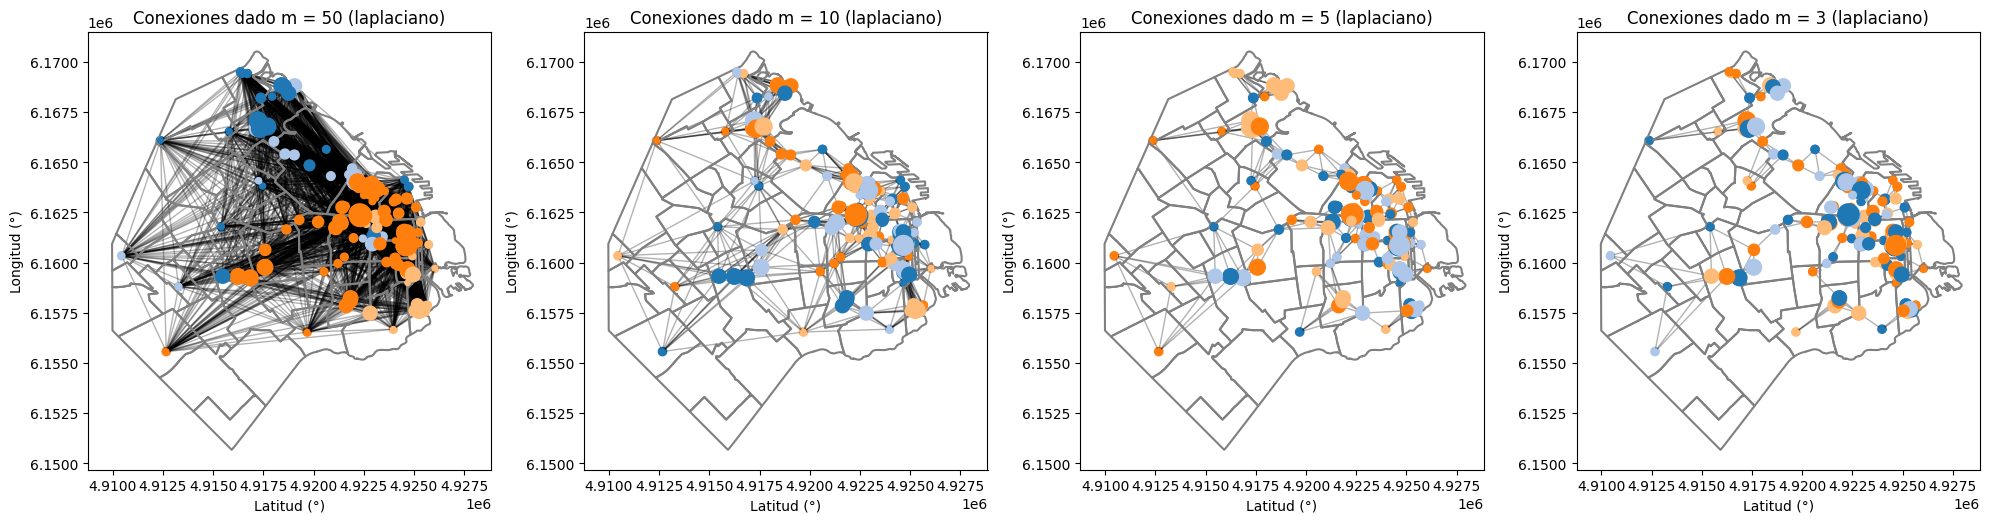

In [ ]:
subplots_aristas(lista_sim, dict_labels,  [f"Conexiones dado m = {m} (laplaciano)" for m in m_list])

In [ ]:
m_list_ext = [_ for _ in range(2, 100+1, 1)]
alfa = 1/5

lista_sim = []

for m in m_list_ext:
  A = construye_adyacencia(D, m)
  A_sim = np.ceil(1/2*(A + A.T))
  lista_sim.append(A_sim)


lista_matrices_modular_ext = [modularidad_iterativo(matriz) for matriz in lista_sim]

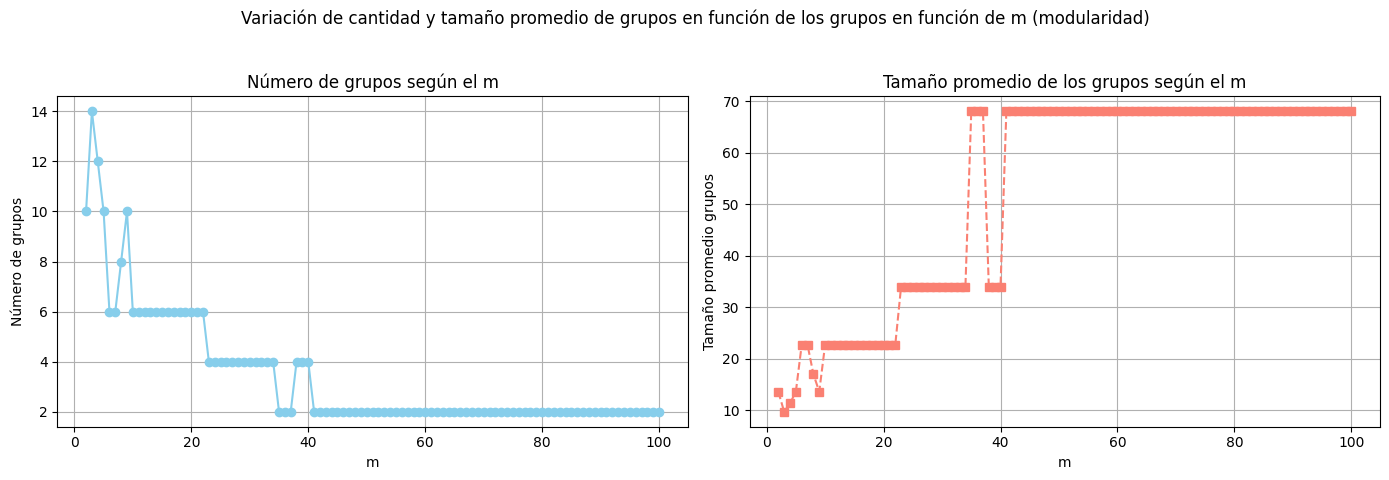

In [ ]:
plot_group_variation_completa(lista_matrices_modular_ext, m_list_ext, tamanio_promedio_grupos(lista_matrices_modular_ext), title="Variación de cantidad y tamaño promedio de grupos en función de los grupos en función de m (modularidad)")

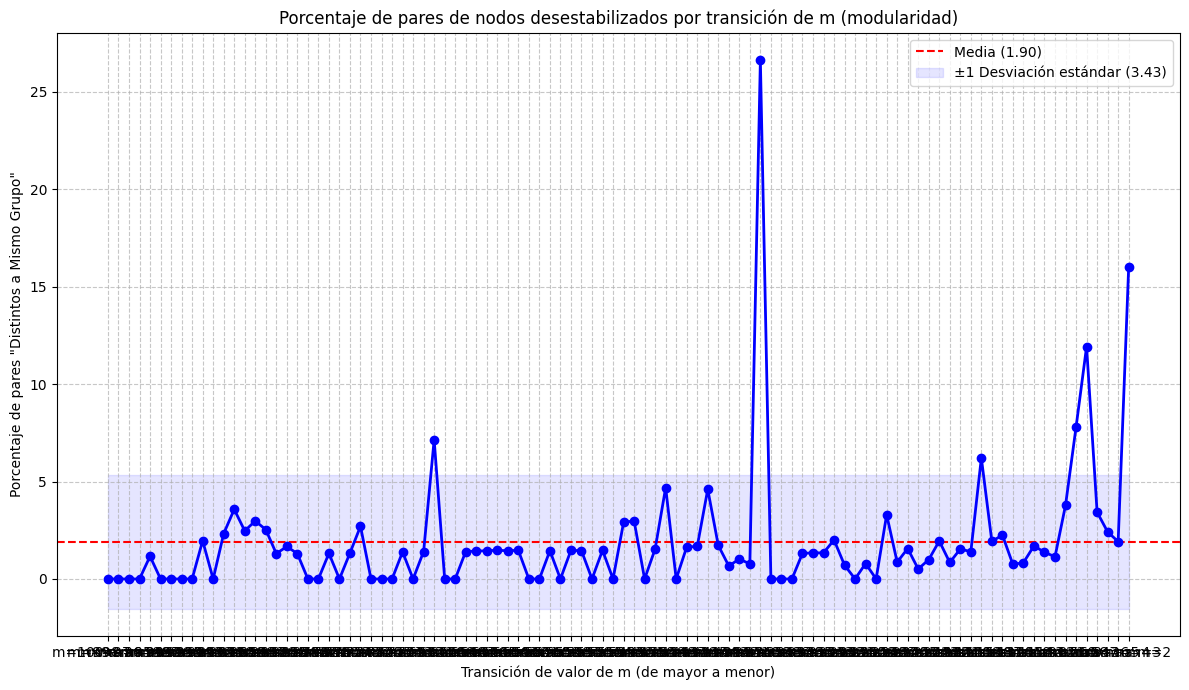

In [ ]:
plot_estabilidad_modularidad(lista_matrices_modular_ext, m_list_ext, "Porcentaje de pares de nodos desestabilizados por transición de m (modularidad)")

In [ ]:
# calculamos todas las matrices

lista_sim = []

for m in m_list_ext:
  A = construye_adyacencia(D, m)
  A_sim = np.ceil(1/2*(A + A.T))
  lista_sim.append(A_sim)

niveles = 2
lista_matrices_laplaciano_ext = [laplaciano_iterativo(matriz, niveles) for matriz in lista_sim]

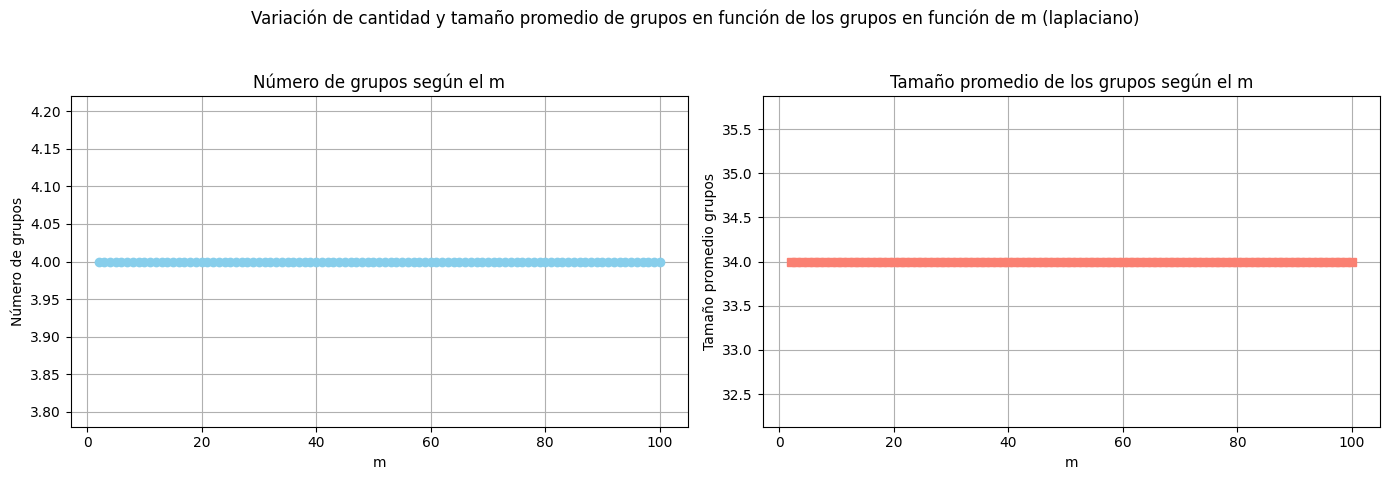

In [ ]:
plot_group_variation_completa(lista_matrices_laplaciano_ext, m_list_ext, tamanio_promedio_grupos(lista_matrices_laplaciano_ext),title="Variación de cantidad y tamaño promedio de grupos en función de los grupos en función de m (laplaciano)")

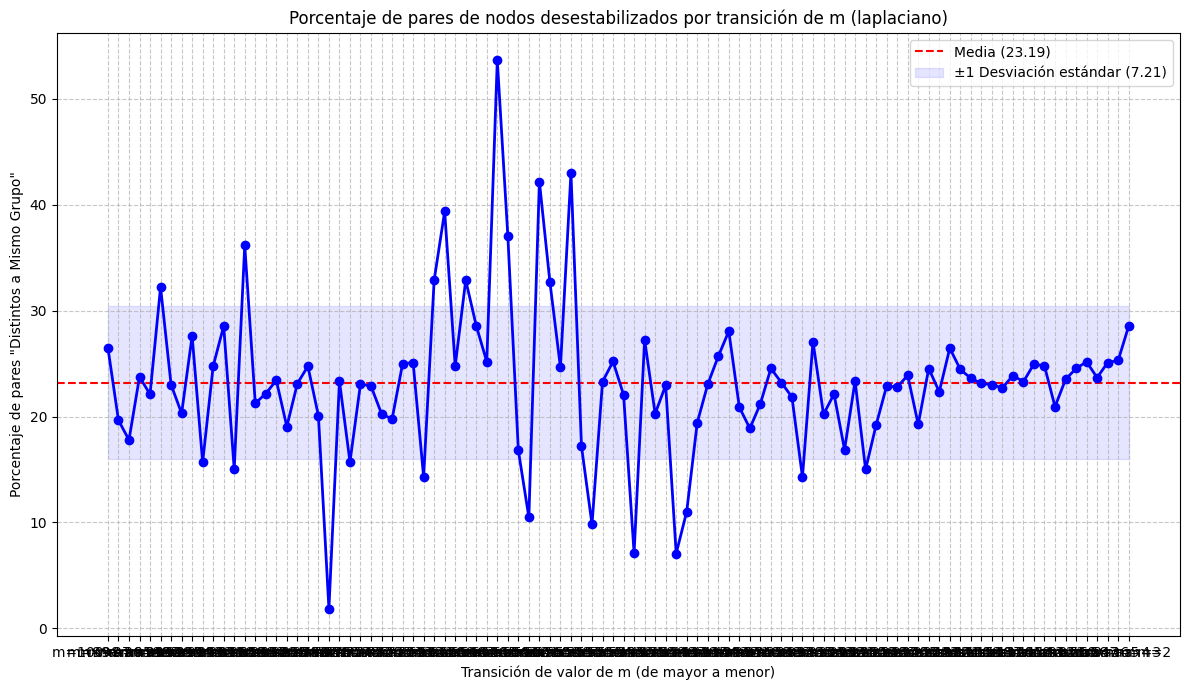

In [ ]:
plot_estabilidad_modularidad(lista_matrices_laplaciano_ext, m_list_ext, "Porcentaje de pares de nodos desestabilizados por transición de m (laplaciano)")


##### Grafico interactivo

# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, ''),
 6: Text(4922856.100832731, 6163868.567721188, ''),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 19:

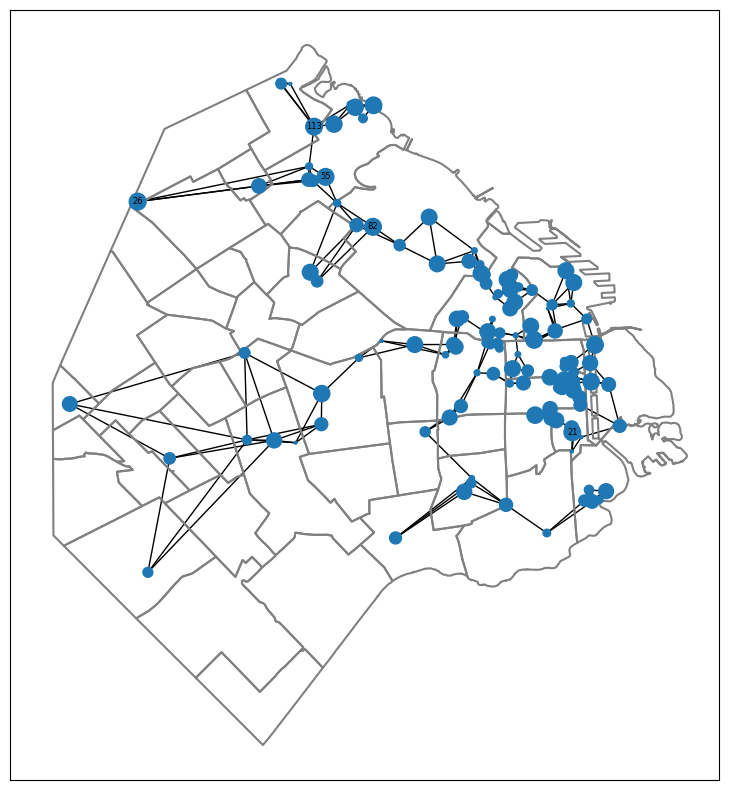

In [ ]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres

In [ ]:

import plotly.graph_objects as go
import shapely
import networkx as nx
import numpy as np

# Función auxiliar: convertir polígonos en líneas para Plotly
def polygon_to_plotly_lines(polygon):
    if isinstance(polygon, shapely.geometry.multipolygon.MultiPolygon):
        polygons = polygon.geoms
    else:
        polygons = [polygon]

    lines = []
    for poly in polygons:
        x, y = poly.exterior.xy
        lines.append(go.Scatter(
            x=list(x), y=list(y),
            mode='lines',
            line=dict(color='lightgray', width=1),
            hoverinfo='skip',
            showlegend=False
        ))
    return lines

# Preparamos coordenadas proyectadas de nodos
museos_proj = museos.to_crs("EPSG:22184")
G_x = museos_proj.get_coordinates()['x']
G_y = museos_proj.get_coordinates()['y']

# Barrios proyectados
barrios_proj = barrios.to_crs("EPSG:22184")

# Iteramos por cada matriz en lista_sim
for i in range(len(lista_sim)):
    A = lista_sim[i]
    G = nx.from_numpy_array(A)

    # Layout basado en coordenadas geográficas
    G_layout = {j: (G_x[j], G_y[j]) for j in G.nodes}

    # Trazas de aristas
    edge_x = []
    edge_y = []
    for u, v in G.edges():
        x0, y0 = G_layout[u]
        x1, y1 = G_layout[v]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='gray'),
        hoverinfo='none',
        mode='lines')

    # Trazas de nodos
    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = G_layout[node]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        marker=dict(
            color=[dict_labels[i][j] for j in G.nodes],
            size=10,
            line_width=1
        ),
        text=[f"nodo {j}" for j in G.nodes],
        hoverinfo='text'
    )

    # Trazas de los polígonos de barrios
    barrio_traces = []
    for geom in barrios_proj.geometry:
        barrio_traces += polygon_to_plotly_lines(geom)

    # Creamos la figura
    fig = go.Figure(
        data=barrio_traces + [edge_trace, node_trace],
        layout=go.Layout(
            title=f"Modularidad con m = {m_list[i]}",
            showlegend=False,
            hovermode='closest',
            margin=dict(b=20, l=5, r=5, t=40),
            xaxis=dict(showgrid=False, zeroline=False),
            yaxis=dict(showgrid=False, zeroline=False, scaleanchor="x"),
        )
    )

    # Mostramos la figura
    fig.show()


KeyError: 4

Algoritmo para tener consistencia entre valores de m
- Precondición: el valor de m siguiente es menor al anterior.

- Algoritmo:
  - Asigno por primera vez colores a mi conjunto.
  - Voy con el próximo m:
    - Para todos los nuevos grupos matcheo cuál tiene mayor coincidencia con respecto a los anteriores.
    - Voy a tener la cantidad de grupos que tenía en mi paso anterior de grupos con color asignado.
    - Le asigno color a los grupos que no tienen.

Observación: esto puede tener complejidad computacional muy alta.

In [ ]:
def asignar_colores(lista_matrices_modular):
    """
    Parámetros
      ----------
      lista_matrices: lista de matrices.

    Devuelve
      ----------
      dict_labels: diccionario cuyas claves son los índices de los puntos y
      cuyos valores son el color que le fue asignado.
    """
    # chequeo que haya mas de 1 matriz en la lista.
    assert len(lista_matrices_modular) > 1

    # agarramos 20 colores que tiene matplotlib.
    colores = plt.cm.tab20.colors

    # diccionario con clave
    dict_grupos = {}
    dict_labels = {}
    for i, matriz in enumerate(lista_matrices_modular):
      # diccionario con clave (indice_grupo_a, indice_grupo_b) -> long. de coincidencia entre elem. entre grupo a y grupo b
      dict_cantidades = {}
      # asigno por primera vez colores a mi grupo.
      if not dict_grupos:
        for j, grupo in enumerate(matriz):
            dict_grupos[colores[j]] = grupo
            for elem in grupo:
              dict_labels[i][elem] = colores[j]
      else:
        matriz_cantidades = np.zeros((len(matriz), len(lista_matrices_modular[i-1])))
        for j in range(len(matriz)): # para cada grupo actual
          for k in range(len(lista_matrices_modular[i-1])): # para cada grupo viejo
            matriz_cantidades[j,k] = len(set(matriz[j]).difference(set(lista_matrices_modular[i-1][k]))) # veo el tamaño de la dif.

        # agarro el máximo de la filas
        for i in range(len(matriz_cantidades[:,i])):
          arg = np.argmax(matriz_cantidades[:,i], axis=0)
